**This model was based on CNN publication by PhD Krzysztof Sopyla:**
[PyTorch CNN Tutorial CIFAR-10](https://ksopyla.com/pytorch/siec-konwolucyjna-pytorch-cifar10/)

# Libraries import, definition of required classes and methods, samples visualization:

In [12]:
#Libraries import and device definition
import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import random
from imgaug import augmenters as iaa
from imgaug import parameters as iap
from PIL import Image
import os, os.path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from datetime import datetime
%matplotlib inline
import numpy as np
import seaborn as sns; sns.set()
from torchsummary import summary
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Assume that we are on a CUDA machine, then this should print a CUDA device:
print(f'Working on device={device}')

Working on device=cuda


In [0]:
#Loading and Saving Function and Method
def load_image(infilename) :
    img = Image.open( infilename )
    img.load()
    data = np.asarray( img, dtype="int32" )
    return data

def save_image(npdata, outfilename) :
    img = Image.fromarray( np.asarray( np.clip(npdata,0,255), dtype="uint8"), "L" )
    img.save(outfilename, "JPEG")

In [0]:
#Generating extra preprocessed images
def augment(img):
  par_1 = random.uniform(0.1, 1.0)
  par_2 = random.uniform(1.0, 15.0)
  par_3 = random.uniform(2.0, 40.0)
  par_4 = random.uniform(0.1, 1.0)
  par_5 = random.uniform(0.1, 1.0)
  par_6 = random.uniform(0.01, 0.2)
  affine = iaa.Affine(rotate=(-10, 10), mode = 'edge')
  img = affine.augment_image(img)
  blurer = iaa.GaussianBlur(iap.Uniform(0.1,par_1)) 
  img = blurer.augment_image(img)
  elastic = iaa.ElasticTransformation(sigma=par_2, alpha=par_3)
  img=elastic.augment_image(img)
  flp=iaa.Flipud(p=par_4)
  img=flp.augment_image(img)
  salt = iaa.SaltAndPepper(p=par_6)
  img=salt.augment_image(img)
  flp2=iaa.Fliplr(p=par_5)
  img=flp2.augment_image(img)
  crop = iaa.CropToFixedSize(1500,1300,position="center-bottom")
  img = crop.augment_image(img)
  return img

In [0]:
# Function to rename multiple files
def renamer(path):
  iterater = 0     
  for filename in os.listdir(path):
    dst = str(iterater) + ".jpg"
    src = path + filename 
    dst = path + dst 
    os.rename(src, dst) 
    iterater += 1

In [0]:
# Images verification method
def verifier(path):    
  for filename in os.listdir(path):
    try:
      img = Image.open(path + filename)
    except (Exception, FileNotFoundError, AttributeError):
      os.remove(path + filename)
    try:
      img.verify()
    except (Exception, FileNotFoundError, AttributeError):
      os.remove(path + filename)

In [0]:
# Extra images generating loop
def img_generator(path, no_gen):
  for i in range(0, no_gen):
    try:
      save_image(augment(load_image(path + str(i) + '.jpg')), path + 'Generated '+ str(i) +'.jpg')
    except (ValueError, OSError):
      pass

In [0]:
#Plot function to visualise NORMAL and PNEUMONIA SCANS
def plot_images(item_dir, top=25):
  all_item_dirs = os.listdir(item_dir)
  item_files = [os.path.join(item_dir, file) for file in all_item_dirs][:top]

  plt.figure(figsize = (12,12))
  for idx, img_path in enumerate(item_files):
    plt.subplot(5,5, idx+1)
    img = mpimg.imread(img_path)
    plt.imshow(img)
  plt.tight_layout()

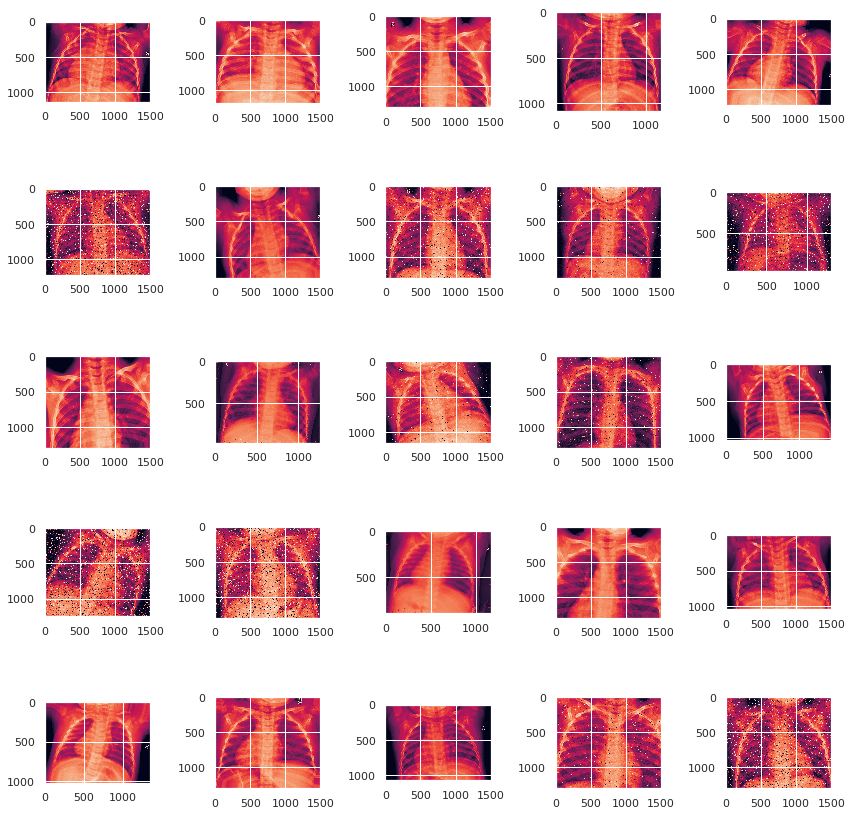

In [113]:
#Visualize training photos - class : Normal
plot_images("./chest_xray/train/NORMAL/")

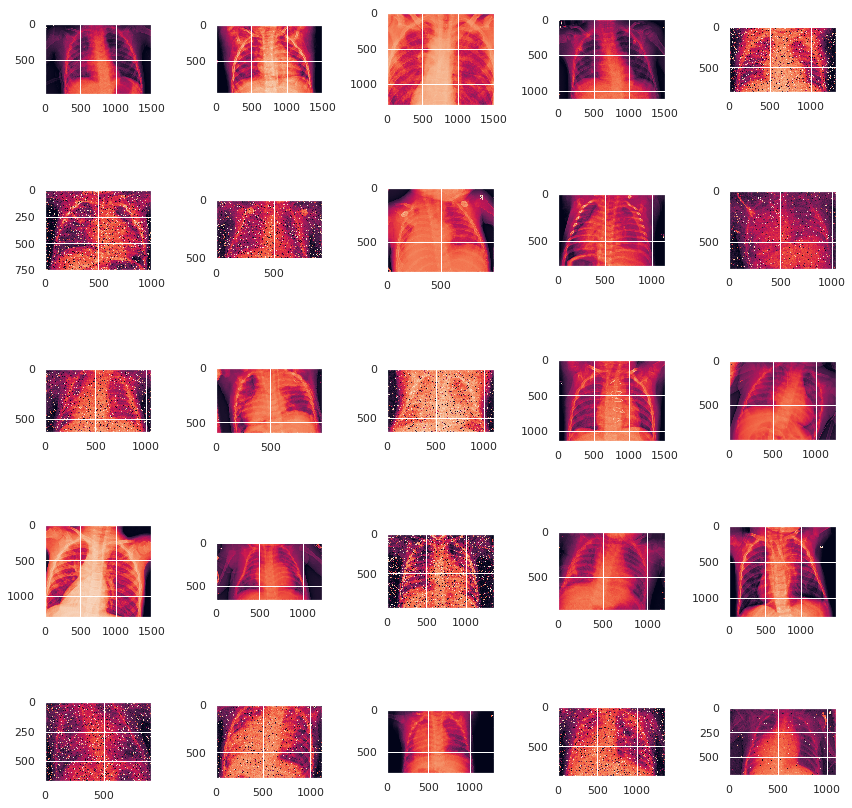

In [114]:
#Visualize training photos - class : Pneumonia
plot_images("./chest_xray/train/PNEUMONIA/")

# Import of the samples, files compability verification, new samples generation process based on imgaug library:

During the generation process there are created four types of the samples corresponding to output classess. Image preprocessing process contains few extra operations defined in augment class above (blur, affine, flips, crop etc.).

In [112]:
normal_len = len(os.listdir('/content/chest_xray/train/NORMAL/'))
pneumo_len = len(os.listdir('/content/chest_xray/train/PNEUMONIA/'))

val_normal_len = len(os.listdir('/content/chest_xray/test/NORMAL/'))
val_pneumo_len = len(os.listdir('/content/chest_xray/test/PNEUMONIA/'))

print("Number of normal cases (train): ", normal_len)
print("Number of pneumonia cases (train): ", pneumo_len)

print("Number of normal cases (test): ", val_normal_len)
print("Number of pneumonia cases (test): ", val_pneumo_len)

Number of normal cases (train):  10983
Number of pneumonia cases (train):  9686
Number of normal cases (test):  2131
Number of pneumonia cases (test):  3356


In [0]:
#Path set up
normal_path = "/content/chest_xray/train/NORMAL/"
pneumonia_path = "/content/chest_xray/train/PNEUMONIA/"

val_normal_path = "/content/chest_xray/test/NORMAL/"
val_pneumo_path = "/content/chest_xray/test/PNEUMONIA/"


In [0]:
#Renaming process on train set
renamer(normal_path)
renamer(pneumonia_path)

In [0]:
#Renaming process on test set
renamer(val_normal_path)
renamer(val_pneumo_path)

In [0]:
#Verification process on train set
verifier(normal_path)
verifier(pneumonia_path)

In [0]:
#Verification process on test set
verifier(val_normal_path)
verifier(val_pneumo_path)

In [0]:
#Extra images generating process Normal
img_generator(normal_path, normal_len)

In [0]:
#Extra images generating process Pneumonia
img_generator(pneumonia_path, pneumo_len)

In [0]:
#Extra images generating process Normal (Test)
img_generator(val_normal_path, val_normal_len)

In [0]:
#Extra images generating process Pneumonia (Test)
img_generator(val_pneumo_path, val_pneumo_len)

# Parameters definition, dataset preparation and model definition:

Input size is equal 224 (H) x 224(W) x 1 (C), batch_size is 16,  2 output classes.
Model contains 6 convolution layers with different kernel sizes. Each section of convolution layers is ended by pooling operation (2x2).
After that 3 linear fully connected layers are defined.

All of dimmentions are described in model summary.

In the data samples transform extra operations are defined (ColorJitter, Random Filps).

In [0]:
#Preprocessing and model variables
hight = 224
width = 224
channels = 1
batch_size = 16
num_classes = 2
num_epochs = 20
learning_rate = 0.001

transform = transforms.Compose(
    [transforms.Resize(size=(hight,width), interpolation=2),
     transforms.Grayscale(1),
     transforms.ColorJitter(brightness=0.05, contrast=0.8, saturation=0.3),
     transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomVerticalFlip(p=0.5),
     transforms.ToTensor(),
     transforms.Normalize((0.485,), (0.229,))])

transform_test = transforms.Compose(
    [transforms.Resize(size=(hight,width), interpolation=2),
     transforms.ToTensor(),
     transforms.Normalize((0.485,), (0.229,))])

classes = ('NORMAL', 'PNEUMONIA')

In [0]:
#Dataset and Dataloader definition
train_data_path = './chest_xray/train/'
test_data_path = './chest_xray/test/'

train_dataset = torchvision.datasets.ImageFolder(
        root=train_data_path,
        transform=transform,
    )
train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        num_workers=0,
        shuffle=True
    )


test_dataset = torchvision.datasets.ImageFolder(
        root=test_data_path,
        transform=transform,
    )
test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=batch_size,
        num_workers=0,
        shuffle=False
    )


In [0]:
#Model definition
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        # channel_in=1 channels_out=16
        self.conv1_1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(16)  
        self.conv1_2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.batchnorm2 = nn.BatchNorm2d(32)  
        self.conv2_1 = nn.Conv2d(32, 32, kernel_size=5, stride=1, padding=1)
        self.batchnorm3 = nn.BatchNorm2d(32)  
        self.conv2_2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=1)
        self.batchnorm4 = nn.BatchNorm2d(64)  
        self.conv2_3 = nn.Conv2d(64, 48, kernel_size=5, stride=1, padding=1)
        self.batchnorm5 = nn.BatchNorm2d(48)  
        self.conv2_4 = nn.Conv2d(48, 192, kernel_size=5, stride=1, padding=1)
        self.batchnorm6 = nn.BatchNorm2d(192)  
        self.fc1 = nn.Linear(192 * 52 * 52, 512)
        self.dropout1 = nn.Dropout2d(0.3) 
        self.fc2 = nn.Linear(512,512)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc3 = nn.Linear(512,512)
        self.output = nn.Linear(512, 2)
        
    def forward(self, x):
        #print("Input data shape: ", x.shape)
        x = self.conv1_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        x = self.conv1_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2_1(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.conv2_2(x)
        x = self.batchnorm4(x)
        x = self.relu(x)
        x = self.conv2_3(x)
        x = self.batchnorm5(x)
        x = self.relu(x)
        x = self.conv2_4(x)
        x = self.batchnorm6(x)
        x = self.relu(x)
        x = self.pool(x)
        #print("After last convolution process: ", x.shape)
        
        x = x.view(-1, 192 * 52 * 52) #192 channels 52x52 size
        
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout2(x)

        x = self.fc3(x)
        x = self.relu(x)      

        x = self.output(x)
        return x

# Model summary and training process:

In [118]:
#Model summary, loss function and optimizer definition
net = ConvNet()
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
summary(net, (channels, hight, width))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             160
       BatchNorm2d-2         [-1, 16, 224, 224]              32
              ReLU-3         [-1, 16, 224, 224]               0
            Conv2d-4         [-1, 32, 224, 224]           4,640
       BatchNorm2d-5         [-1, 32, 224, 224]              64
              ReLU-6         [-1, 32, 224, 224]               0
         MaxPool2d-7         [-1, 32, 112, 112]               0
            Conv2d-8         [-1, 32, 110, 110]          25,632
       BatchNorm2d-9         [-1, 32, 110, 110]              64
             ReLU-10         [-1, 32, 110, 110]               0
           Conv2d-11         [-1, 64, 108, 108]          51,264
      BatchNorm2d-12         [-1, 64, 108, 108]             128
             ReLU-13         [-1, 64, 108, 108]               0
           Conv2d-14         [-1, 48, 1

In [119]:
#Model training
accuracy_index = []
losses_index = []
for epoch in range(num_epochs):  # loop over the dataset multiple times
    start_time = datetime.now()
    net.train()
    running_loss = 0.0
    epoch_loss = 0
    for i, data in enumerate(train_loader, 0):
        # get the inputs
        inputs, labels = data
        # move data to device GPU OR CPU
        inputs, labels = inputs.to(device), labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss = epoch_loss / len(train_loader)
    time_elapsed = datetime.now() - start_time
    losses_index.append(epoch_loss)
    
    # Test the model, set our model in the training mode
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    # Accuracy of the network on the 10000 test images
    acc = correct/total
    accuracy_index.append(acc)
    
    
    print(
        f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f} Test acc: {acc:.4f} time={time_elapsed}')
    

Epoch [1/20], Loss: 0.5884 Test acc: 0.8199 time=0:14:32.256464
Epoch [2/20], Loss: 0.2489 Test acc: 0.8272 time=0:12:50.950932
Epoch [3/20], Loss: 0.1905 Test acc: 0.8309 time=0:12:47.914920
Epoch [4/20], Loss: 0.1652 Test acc: 0.8269 time=0:12:47.579375
Epoch [5/20], Loss: 0.1512 Test acc: 0.8270 time=0:12:43.000753
Epoch [6/20], Loss: 0.1800 Test acc: 0.8345 time=0:12:43.594792
Epoch [7/20], Loss: 0.1378 Test acc: 0.8498 time=0:12:41.941358
Epoch [8/20], Loss: 0.1067 Test acc: 0.8445 time=0:12:43.097257
Epoch [9/20], Loss: 0.1104 Test acc: 0.8172 time=0:12:46.669139
Epoch [10/20], Loss: 0.1028 Test acc: 0.8622 time=0:12:47.400770
Epoch [11/20], Loss: 0.1195 Test acc: 0.8198 time=0:12:47.690667
Epoch [12/20], Loss: 0.0969 Test acc: 0.8467 time=0:12:43.459786
Epoch [13/20], Loss: 0.0942 Test acc: 0.8156 time=0:12:42.538853
Epoch [14/20], Loss: 0.0829 Test acc: 0.8081 time=0:12:44.503241
Epoch [15/20], Loss: 0.0667 Test acc: 0.8475 time=0:12:42.019818
Epoch [16/20], Loss: 0.0714 Test a

# Training process visualization:

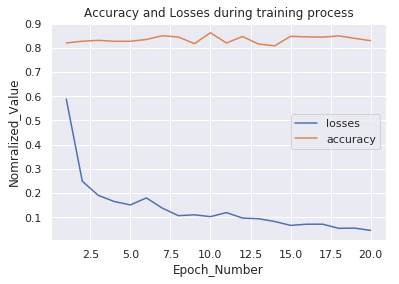

In [121]:
#Plotting testing results
num_numbers = list(range(1,num_epochs+1))
ax1 = sns.lineplot(x=num_numbers,y=losses_index, label="losses")
ax1.set(xlabel='Epoch_Number', ylabel='Nomralized_Value')
ax1.set_title("Accuracy and Losses during training process")
ax2 = sns.lineplot(x=num_numbers,y=accuracy_index, label="accuracy")

# Model to device transfering and test prediction:

In [122]:
#Move model to GPU
net.cuda()

ConvNet(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (conv1_1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1_2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_1): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (batchnorm3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (batchnorm4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_3): Conv2d(64, 48, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (batchnorm5): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_4): Co

In [0]:
#Test image import class definition
from PIL import Image

def image_loader(loader, image_name):
    image = Image.open(image_name)
    image = loader(image).float()
    image = torch.tensor(image, requires_grad=True)
    image = image.unsqueeze(0)
    return image

In [124]:
#Test image loading, moving into GPU
test_image = image_loader(transform_test, '/content/chest_xray/val/PNEUMONIA/person1951_bacteria_4882.jpeg')
test_image = test_image.cuda()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


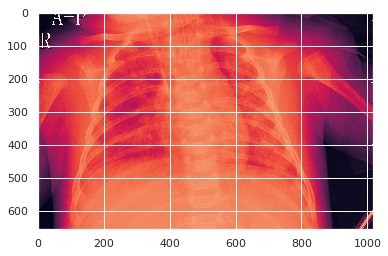

1
PNEUMONIA


In [125]:
#Raw Test photo visualization and prediction
img_raw = Image.open('/content/chest_xray/val/PNEUMONIA/person1951_bacteria_4882.jpeg')
plt.imshow(img_raw)
plt.show()


prediction = net(test_image).cpu()


result =  int(torch.max(prediction.data, 1)[1].numpy())

print(result)
if result == 0:
    print("NORMAL")
elif result == 1:
    print("PNEUMONIA")